In [ ]:
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import time
from tensorflow import keras
from tensorflow.keras import layers
import os

In [ ]:
pip install extra-keras-datasets

  Created wheel for extra-keras-datasets: filename=extra_keras_datasets-0.1.7-cp36-none-any.whl size=7312 sha256=3691f38e4cbb11fb109d9b835d54145cab17fb1865945652a622a7bb0894e050
  Stored in directory: /root/.cache/pip/wheels/8a/04/95/e8f214025c2e40d5618a443e4ea09df0031050b35460ea007c
Successfully built extra-keras-datasets


In [ ]:
from extra_keras_datasets import emnist

743907328/743900280 [==============================] - 60s 0us/step
(124800, 28, 28)
(124800, 28, 28, 1)


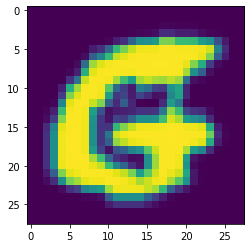

In [ ]:
(train_images,train_labels),(test_images,test_labels) = emnist.load_data(type='letters')
plt.imshow(train_images[1])
print(train_images.shape)


train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
print(train_images.shape)

BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 256
train_images

train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
train_dataset

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
  
    return model


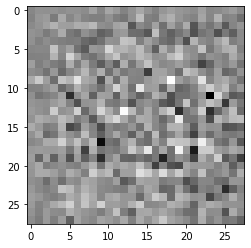

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])#giving random input vector
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')#printing the generated image by the generator from the rando vector

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image) #giving the generated image to discriminator,the discriminator will give negative value if it is fake,while if it is real then it will give positive value.
print (decision)



tf.Tensor([[0.00103833]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)#creating loss function

In [ ]:
def generator_loss(generated_output):
    return cross_entropy(tf.ones_like(generated_output),generated_output)

In [ ]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = cross_entropy(tf.zeros_like(generated_output),generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [ ]:
generator_optimizer = tf.optimizers.Adam(1e-4)
discriminator_optimizer = tf.optimizers.Adam(1e-4)

In [ ]:
# checkpoint_dir = './training_checkpoints'
checkpoint_dir = '/content/drive/My Drive/GAN2/Checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 2
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
  
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/GAN2'

/content/drive/My Drive/GAN2


In [ ]:
take_input = input('Is it the first time you are running the model (y/n) : ')

Is it the first time you are running the model (y/n) : y


In [ ]:
if take_input == 'y':
    file = open('runtime_count.txt' , 'w')
    count = 1
    flag = 0
    file.write(str(count))
    file.close()


    def generate_and_save_images(model, epoch, test_input):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = model(test_input, training=False)

        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            # plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        file = open('epoch_count.txt' , 'w')
        file.write(str(epoch))
        file.close()
        plt.savefig('{}_image_at_epoch_{:01d}.png'.format(count , epoch))
        plt.show()
else:
    #run this code only if there is a runtime disconnection
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    flag = 1

In [ ]:
if flag == 1:
    file = open('runtime_count.txt', 'r')
    doc = file.read()
    file.close()

    file_1 = open('epoch_count.txt', 'r')
    doc_1 = file_1.read()
    file_1.close()

    count_new = int(doc) + 1
    def generate_and_save_images(model, epoch, test_input):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = model(test_input, training=False)

        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            # plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        epoch = epoch + int(doc_1)
        file = open('epoch_count.txt' , 'w')
        file.write(str(epoch))
        file.close()
        plt.savefig('{}_image_at_epoch_{:01d}.png'.format(count_new , epoch))
        plt.show()

    file = open('runtime_count.txt' , 'w')
    file.write(str(count_new))
    file.close()
else:
    print('the code is running for the first time')

the code is running for the first time


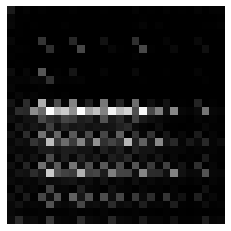

Time for epoch 1 is 35.61136341094971 sec


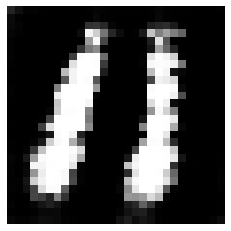

Time for epoch 2 is 35.54125213623047 sec


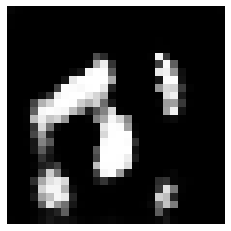

Time for epoch 3 is 35.431021213531494 sec


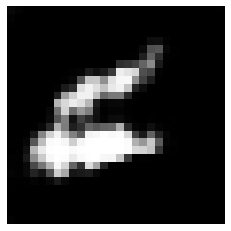

Time for epoch 4 is 35.94535446166992 sec


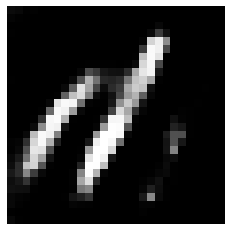

Time for epoch 5 is 36.33166313171387 sec


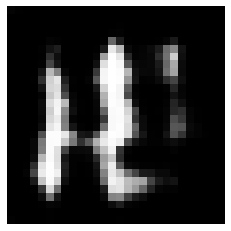

Time for epoch 6 is 36.70074129104614 sec


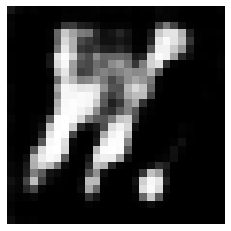

Time for epoch 7 is 36.59564399719238 sec


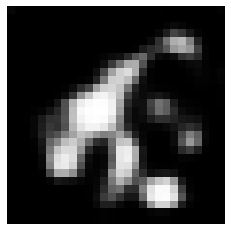

Time for epoch 8 is 36.688727378845215 sec


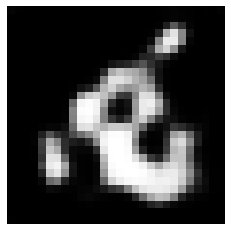

Time for epoch 9 is 36.506678104400635 sec


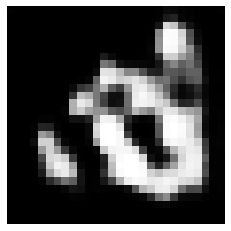

Time for epoch 10 is 36.67343831062317 sec


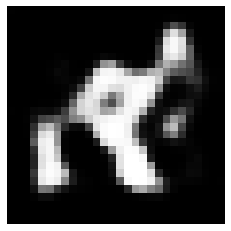

Time for epoch 11 is 37.03718090057373 sec


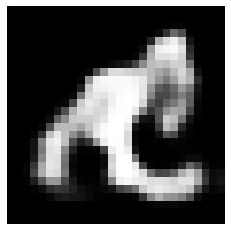

Time for epoch 12 is 36.81754231452942 sec


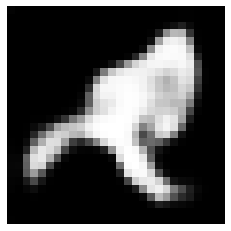

Time for epoch 13 is 36.83177590370178 sec


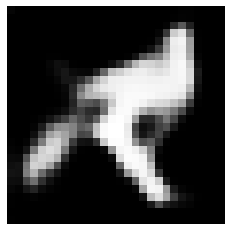

Time for epoch 14 is 36.789068937301636 sec


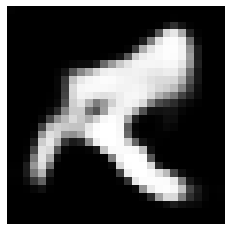

Time for epoch 15 is 36.85156059265137 sec


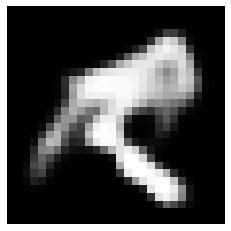

Time for epoch 16 is 37.29377341270447 sec


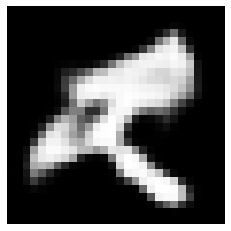

Time for epoch 17 is 37.373117208480835 sec


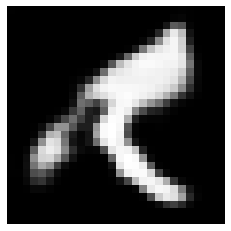

Time for epoch 18 is 36.98563838005066 sec


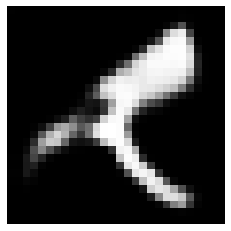

Time for epoch 19 is 37.17105770111084 sec


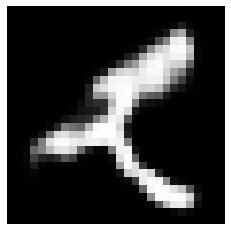

Time for epoch 20 is 37.08180212974548 sec


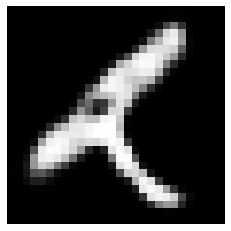

Time for epoch 21 is 37.38834547996521 sec


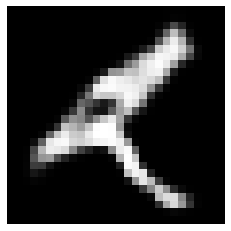

Time for epoch 22 is 37.150700092315674 sec


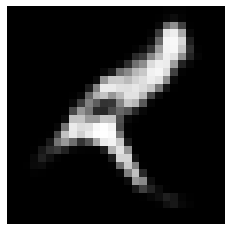

Time for epoch 23 is 37.080671072006226 sec


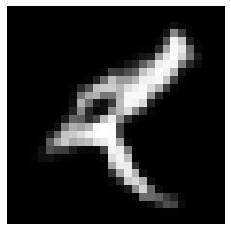

Time for epoch 24 is 37.10995316505432 sec


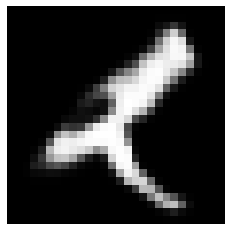

Time for epoch 25 is 36.96718192100525 sec


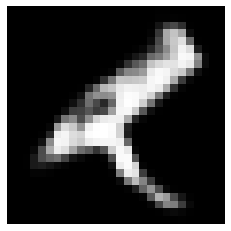

Time for epoch 26 is 37.109407901763916 sec


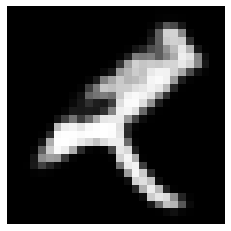

Time for epoch 27 is 37.22307634353638 sec


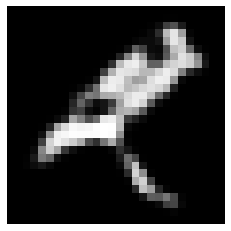

Time for epoch 28 is 37.283482789993286 sec


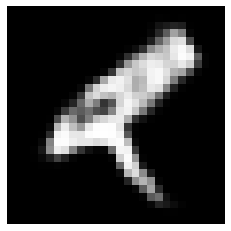

Time for epoch 29 is 37.155028343200684 sec


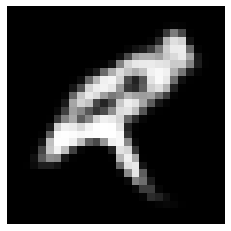

Time for epoch 30 is 37.297507524490356 sec


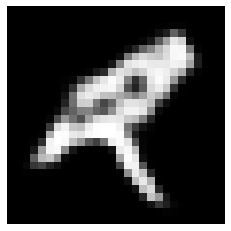

Time for epoch 31 is 37.111510276794434 sec


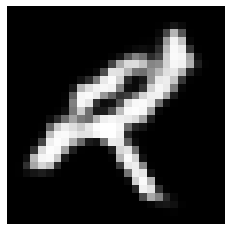

Time for epoch 32 is 37.18251276016235 sec


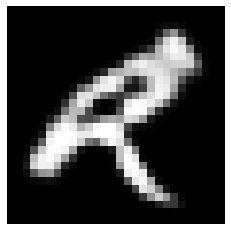

Time for epoch 33 is 37.060532569885254 sec


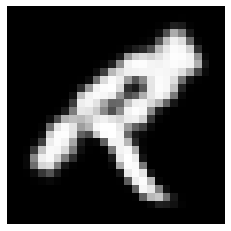

Time for epoch 34 is 37.24565410614014 sec


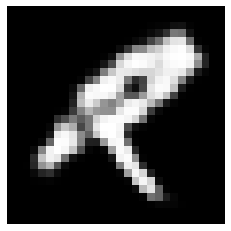

Time for epoch 35 is 37.152610301971436 sec


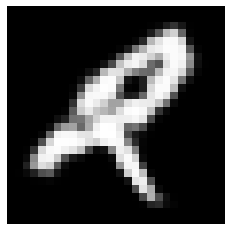

Time for epoch 36 is 37.176079511642456 sec


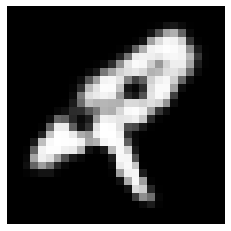

Time for epoch 37 is 37.13796043395996 sec


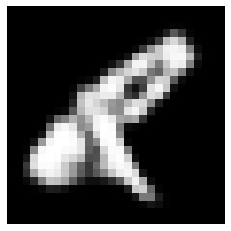

Time for epoch 38 is 37.15424728393555 sec


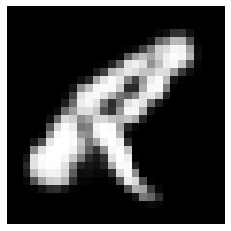

Time for epoch 39 is 37.3658242225647 sec


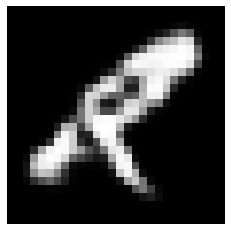

Time for epoch 40 is 37.19572710990906 sec


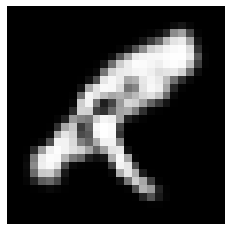

Time for epoch 41 is 37.14455986022949 sec


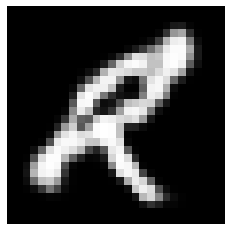

Time for epoch 42 is 37.25218057632446 sec


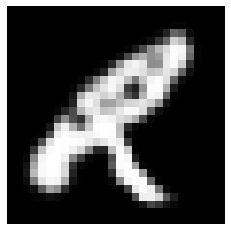

Time for epoch 43 is 37.24933099746704 sec


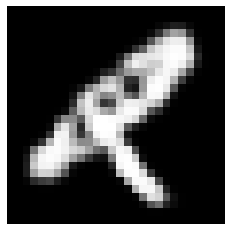

Time for epoch 44 is 37.254241704940796 sec


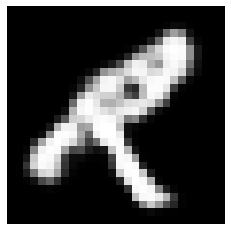

Time for epoch 45 is 37.324806928634644 sec


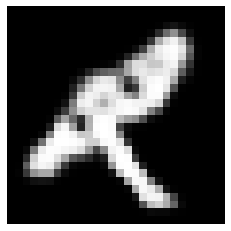

Time for epoch 46 is 37.357115030288696 sec


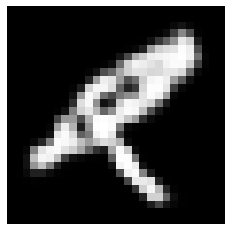

Time for epoch 47 is 37.23990535736084 sec


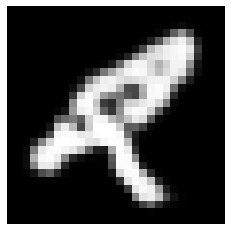

Time for epoch 48 is 37.22421050071716 sec


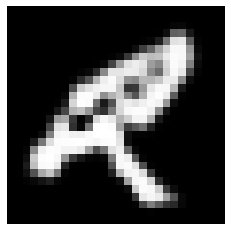

Time for epoch 49 is 37.222182750701904 sec


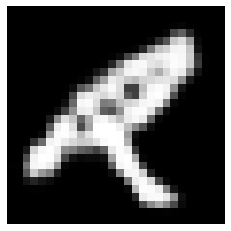

Time for epoch 50 is 37.190484046936035 sec


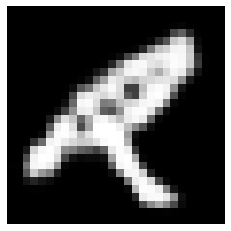

In [ ]:
train(train_dataset, EPOCHS)